In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [2]:
!pip install rasterio -q
!pip install geopandas -q
!pip install xgboost -q
!pip install skranger -q

In [3]:
import importlib.util

spec = importlib.util.spec_from_file_location("script", '/content/MyDrive/MyDrive/GEE_SOP/modules/script.py')
script_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(script_module)

script_module.Script.work()

it's working!


In [4]:
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor , BaggingRegressor, StackingRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from skranger.ensemble import RangerForestRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score

from sklearn.linear_model import Lasso, Ridge

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [5]:
!ls /content/MyDrive/MyDrive/GEE_SOP

Area_0709_2017.tif  Datasets.csv	model_carbon_prediction.joblib	SOP
BARY		    DIOHENE		modules				Sop.csv
Bary.csv	    Diohene.csv		sentinel2_0607_2016.tif		SopMNT.tif
BaryMNT.tif	    DioheneMNT.tif	sentinel2_0709_2017.tif		SopTIF2017.tif
BaryTIF2017.tif     DioheneTIF2017.tif	sentinel2_0810_2016.tif
Dataset		    MNT.tif		sentinel2_1112_2016.tif


In [6]:
dataset = gpd.read_file('/content/MyDrive/MyDrive/GEE_SOP/Dataset/Datasets.shp')

In [7]:
dataset = dataset.drop(columns=['field_1','Site'])
dataset['Date'] = pd.to_datetime(dataset['Date'], dayfirst=True)
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['Stock_C (M'] = dataset['Stock_C (M'].str.replace(',', '.').astype(float)
dataset['Epaisseur_'] = dataset['Epaisseur_'].astype(float)
dataset['Profondeur'] = dataset['Profondeur'].astype(float)

dataset = dataset.rename(columns={'Stock_C (M':'Carbon','Epaisseur_':'Epaisseur'})
dataset = dataset.drop(columns=['Date'])

In [8]:
columns_0607_2016 = ['B_0607_201','B_0607_2_1','B_0607_2_2','B_0607_2_3','B_0607_2_4','B_0607_2_5','B_0607_2_6','B_0607_2_7','B_0607_2_8','B_0607_2_9','B_0607_210','B_0607_211','B_0607_212']
columns_0810_2016 = ['B_0810_201','B_0810_2_1','B_0810_2_2','B_0810_2_3','B_0810_2_4','B_0810_2_5','B_0810_2_6','B_0810_2_7','B_0810_2_8','B_0810_2_9','B_0810_210','B_0810_211','B_0810_212']
columns_1112_2016 = ['B_1112_201','B_1112_2_1','B_1112_2_2','B_1112_2_3','B_1112_2_4','B_1112_2_5','B_1112_2_6','B_1112_2_7','B_1112_2_8','B_1112_2_9','B_1112_210','B_1112_211','B_1112_212']
columns_0709_2017 = ['B_0709_201','B_0709_2_1','B_0709_2_2','B_0709_2_3','B_0709_2_4','B_0709_2_5','B_0709_2_6','B_0709_2_7','B_0709_2_8','B_0709_2_9','B_0709_210','B_0709_211','B_0709_212']

# Combiner les listes de colonnes
columns_0810_1112_0709 = columns_0810_2016 + columns_1112_2016 + columns_0709_2017
columns_0607_1112_0709 = columns_0607_2016 + columns_1112_2016 + columns_0709_2017
columns_0607_0810_0709 = columns_0607_2016 + columns_0810_2016 + columns_0709_2017
columns_0607_0810_1112 = columns_0607_2016 + columns_0810_2016 + columns_1112_2016

df_0607_2016  = dataset.drop(columns=columns_0810_1112_0709)[(dataset['Year'] == 2016) & (dataset['Month'].isin([6, 7]))]
df_0810_2016  = dataset.drop(columns=columns_0607_1112_0709)[(dataset['Year'] == 2016) & (dataset['Month'].isin([8, 9]))]
df_1112_2016  = dataset.drop(columns=columns_0607_0810_0709)[(dataset['Year'] == 2016) & (dataset['Month'] == 11)]
df_0709_2017  = dataset.drop(columns=columns_0607_0810_1112)[(dataset['Year'] == 2017) & (dataset['Month'] == 8)]

df_0607_2016.rename(columns=lambda x: x.replace('B_0607_2', 'B'), inplace=True)
df_0810_2016.rename(columns=lambda x: x.replace('B_0810_2', 'B'), inplace=True)
df_1112_2016.rename(columns=lambda x: x.replace('B_1112_2', 'B'), inplace=True)
df_0709_2017.rename(columns=lambda x: x.replace('B_0709_2', 'B'), inplace=True)

part1 = pd.concat([df_0607_2016, df_0810_2016],axis=0)
part2 = pd.concat([df_1112_2016, df_0709_2017],axis=0)
final_dataset = pd.concat([part1, part2],axis=0)
final_dataset  = final_dataset.drop(columns=['Month','Year'])

final_dataset = final_dataset.rename(columns={'B01':'B_1','B_1':'B_2','B_2':'B_3','B_3':'B_4','B_4':'B_5','B_5':'B_6','B_6':'B_7','B_7':'B_8','B_8':'B_8A','B10':'B_10','B11':'B_11','B12':'B_12'})

In [9]:
def calculate_indices(row):
    # Extraire les valeurs de pixel des bandes
    B_1 = row['B_1']
    B_2 = row['B_2']
    B_3 = row['B_3']
    B_4 = row['B_4']
    B_5 = row['B_5']
    B_6 = row['B_6']
    B_7 = row['B_7']
    B_8 = row['B_8']
    B_8A = row['B_8A']
    B_9 = row['B_9']
    B_10 = row['B_10']
    B_11 = row['B_11']
    B_12 = row['B_12']

    # Calcul du NDVI
    ndvi = (B_8 - B_4) / (B_8 + B_4)

    # Calcul du GDVI
    gdvi = (B_8 - B_3) / (B_8 + B_3)

    # Calcul du MSAVI2
    msavi2 = (2 * B_8 + 1 - ((2 * B_8 + 1) ** 2 - 8 * (B_8 - B_4)) ** 0.5) / 2

    # Calcul du PSRINIR
    psrinir = B_8 / B_5

    # Calcul du NDWI
    ndwi = (B_3 - B_8) / (B_3 + B_8)

    # Calcul du CIGreen
    cigreen = (B_4 - B_3) / (B_4 + B_3)

    return pd.Series({'NDVI': ndvi, 'GDVI': gdvi, 'MSAVI2': msavi2, 'PSRINIR': psrinir, 'NDWI': ndwi, 'CIGreen': cigreen})

# Appliquer la fonction de calcul des indices à chaque ligne du dataset
indices_df = final_dataset.apply(calculate_indices, axis=1)

# Ajouter les colonnes des indices calculés au dataset
final_dataset = pd.concat([final_dataset, indices_df], axis=1)

In [ ]:
#final_dataset.to_csv("/content/MyDrive/MyDrive/GEE_SOP/Dataset/Data_to_Analyze.csv")

In [10]:
final_dataset = final_dataset.drop(columns=['X_Centroid','Y_Centroid','geometry','Epaisseur'])

In [11]:
final_dataset

Carbon  Profondeur      B_1      B_2      B_3      B_4      B_5  \
1550    4.18        10.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1551    4.13        30.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1552    5.26        10.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1553    9.16        30.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1554   11.89        10.0  0.17195  0.15525  0.16585  0.21200  0.22515   
...      ...         ...      ...      ...      ...      ...      ...   
2641    8.24        30.0  0.16600  0.16980  0.19530  0.25750  0.25210   
2642    4.88        10.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2643    7.56        30.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2644    6.71        10.0  0.16130  0.15570  0.17380  0.22290  0.21500   
2645    8.26        30.0  0.16130  0.15570  0.17380  0.22290  0.21500   

          B_6      B_7      B_8  ...     B_10     B_11     B_12      MNT_1  \
1550  0.30435  0.34395  0.32845  ...  0.00245  0.51945  0.41065  12.962011   
1551  0.30435  0.34395  0.32845  ...  0.00245  0.51945  0.41065  12.962011   
1552  0.31295  0.35765  0.33275  ...  0.00245  0.53790  0.42455  15.547010   
1553  0.31295  0.35765  0.33275  ...  0.00245  0.53790  0.42455  15.547010   
1554  0.26460  0.30620  0.28835  ...  0.00245  0.47470  0.34885        NaN   
...       ...      ...      ...  ...      ...      ...      ...        ...   
2641  0.32880  0.37690  0.35920  ...  0.00180  0.44340  0.32470  18.997011   
2642  0.27350  0.31270  0.30760  ...  0.00180  0.40540  0.29490  21.105345   
2643  0.27350  0.31270  0.30760  ...  0.00180  0.40540  0.29490  21.105345   
2644  0.31960  0.36300  0.35240  ...  0.00180  0.40930  0.29930  19.088678   
2645  0.31960  0.36300  0.35240  ...  0.00180  0.40930  0.29930  19.088678   

          NDVI      GDVI    MSAVI2   PSRINIR      NDWI   CIGreen  
1550  0.099782  0.243305  0.075370  1.202013 -0.243305  0.147093  
1551  0.099782  0.243305  0.075370  1.202013 -0.243305  0.147093  
1552  0.101092  0.248593  0.076924  1.173721 -0.248593  0.151303  
1553  0.101092  0.248593  0.076924  1.173721 -0.248593  0.151303  
1554  0.152593  0.269705  0.103663  1.280702 -0.269705  0.122138  
...        ...       ...       ...       ...       ...       ...  
2641  0.164910  0.295582  0.127883  1.424831 -0.295582  0.137367  
2642  0.195492  0.275290  0.136021  1.424734 -0.275290  0.084337  
2643  0.195492  0.275290  0.136021  1.424734 -0.275290  0.084337  
2644  0.225100  0.339415  0.168598  1.639070 -0.339415  0.123771  
2645  0.225100  0.339415  0.168598  1.639070 -0.339415  0.123771  

[3626 rows x 22 columns]

In [12]:
median_mnt1 = final_dataset['MNT_1'].median()
final_dataset['MNT_1'] = final_dataset['MNT_1'].fillna(median_mnt1)

In [13]:
final_dataset.isna().sum()

Carbon        0
Profondeur    0
B_1           0
B_2           0
B_3           0
B_4           0
B_5           0
B_6           0
B_7           0
B_8           0
B_8A          0
B_9           0
B_10          0
B_11          0
B_12          0
MNT_1         0
NDVI          0
GDVI          0
MSAVI2        0
PSRINIR       0
NDWI          0
CIGreen       0
dtype: int64

In [14]:
# Fonction pour remplacer les valeurs aberrantes par un quantile proche
def replace_outliers_with_quantile(df, column, lower_quantile=0.05, upper_quantile=0.95):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_value = df[column].quantile(lower_quantile)
    upper_value = df[column].quantile(upper_quantile)

    df[column] = np.where(df[column] < lower_bound, lower_value, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_value, df[column])

    # # Filtrer les valeurs aberrantes
    # filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


final_dataset = replace_outliers_with_quantile(final_dataset, 'Carbon')

In [15]:
final_dataset

Carbon  Profondeur      B_1      B_2      B_3      B_4      B_5  \
1550    4.18        10.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1551    4.13        30.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1552    5.26        10.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1553    9.16        30.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1554   11.89        10.0  0.17195  0.15525  0.16585  0.21200  0.22515   
...      ...         ...      ...      ...      ...      ...      ...   
2641    8.24        30.0  0.16600  0.16980  0.19530  0.25750  0.25210   
2642    4.88        10.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2643    7.56        30.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2644    6.71        10.0  0.16130  0.15570  0.17380  0.22290  0.21500   
2645    8.26        30.0  0.16130  0.15570  0.17380  0.22290  0.21500   

          B_6      B_7      B_8  ...     B_10     B_11     B_12      MNT_1  \
1550  0.30435  0.34395  0.32845  ...  0.00245  0.51945  0.41065  12.962011   
1551  0.30435  0.34395  0.32845  ...  0.00245  0.51945  0.41065  12.962011   
1552  0.31295  0.35765  0.33275  ...  0.00245  0.53790  0.42455  15.547010   
1553  0.31295  0.35765  0.33275  ...  0.00245  0.53790  0.42455  15.547010   
1554  0.26460  0.30620  0.28835  ...  0.00245  0.47470  0.34885  14.897013   
...       ...      ...      ...  ...      ...      ...      ...        ...   
2641  0.32880  0.37690  0.35920  ...  0.00180  0.44340  0.32470  18.997011   
2642  0.27350  0.31270  0.30760  ...  0.00180  0.40540  0.29490  21.105345   
2643  0.27350  0.31270  0.30760  ...  0.00180  0.40540  0.29490  21.105345   
2644  0.31960  0.36300  0.35240  ...  0.00180  0.40930  0.29930  19.088678   
2645  0.31960  0.36300  0.35240  ...  0.00180  0.40930  0.29930  19.088678   

          NDVI      GDVI    MSAVI2   PSRINIR      NDWI   CIGreen  
1550  0.099782  0.243305  0.075370  1.202013 -0.243305  0.147093  
1551  0.099782  0.243305  0.075370  1.202013 -0.243305  0.147093  
1552  0.101092  0.248593  0.076924  1.173721 -0.248593  0.151303  
1553  0.101092  0.248593  0.076924  1.173721 -0.248593  0.151303  
1554  0.152593  0.269705  0.103663  1.280702 -0.269705  0.122138  
...        ...       ...       ...       ...       ...       ...  
2641  0.164910  0.295582  0.127883  1.424831 -0.295582  0.137367  
2642  0.195492  0.275290  0.136021  1.424734 -0.275290  0.084337  
2643  0.195492  0.275290  0.136021  1.424734 -0.275290  0.084337  
2644  0.225100  0.339415  0.168598  1.639070 -0.339415  0.123771  
2645  0.225100  0.339415  0.168598  1.639070 -0.339415  0.123771  

[3626 rows x 22 columns]

In [ ]:
#dataset.to_csv('/content/MyDrive/MyDrive/GEE_SOP/SOP/sop_data.csv')

In [16]:
X = np.array(final_dataset.drop(columns=['Carbon']))
Y = np.array(final_dataset['Carbon'])

In [17]:
X_train , X_test , Y_train , Y_test = train_test_split( X , Y , test_size=0.2 , random_state=42 )

In [ ]:
estimator = HistGradientBoostingRegressor(max_iter = 300, max_depth = 5,random_state=42)

# Définir les paramètres pour la recherche par grille
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_leaf_nodes': [31, 50, 100],
    'min_samples_leaf': [20, 50, 100],
    'max_bins': [255, 511]
}

# Configurer GridSearchCV
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Exécuter GridSearchCV
grid_search.fit(X_train, Y_train)

# Afficher les meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres trouvés: {grid_search.best_params_}")

# Utiliser les meilleurs hyperparamètres pour faire des prédictions
best_rf = grid_search.best_estimator_
predictions = best_rf.predict(X_test)

# Évaluer les performances du modèle
mse = mean_squared_error(Y_test, predictions)
print(f"Mean Squared Error sur le set de test: {mse}")

In [18]:
# Définir les modèles individuels
xgb_model = XGBRegressor( n_estimators = 100, max_depth = 5, random_state=42)
lgbmr = lgb.LGBMRegressor(n_estimators = 300, max_depth = 5, num_leaves = 50, force_col_wise=True)
gbr = GradientBoostingRegressor(n_estimators = 200, max_depth =  5)
hgb = HistGradientBoostingRegressor(max_iter=300, max_depth=5, learning_rate = 0.1, max_bins = 255, max_leaf_nodes = 31, min_samples_leaf = 20, random_state=42)


# Créer les pipelines pour chaque modèle
xgb_pipeline = make_pipeline(StandardScaler(), xgb_model)
lgbmr_pipeline = make_pipeline(StandardScaler(),lgbmr)
gbr_pipeline = make_pipeline(StandardScaler(),gbr)
hgb_pipeline = make_pipeline(StandardScaler(),hgb)

# Créer l'ensemble de modèles
estimators = [
              ('lgbmr', lgbmr_pipeline),
              ('gbr',gbr_pipeline),
              ('XGBRegressor',xgb_pipeline),
              ('HistGradientBoostingRegressor', hgb_pipeline),
            ]

final_estimator = RidgeCV(alphas = [0.01, 0.1, 1.0, 10.0, 100.0], cv = 3, fit_intercept = False, gcv_mode = 'auto', scoring = None, store_cv_values = False)
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator, cv = 5)

In [19]:
history = model.fit(X_train,Y_train)

[LightGBM] [Info] Total Bins 4951
[LightGBM] [Info] Number of data points in the train set: 2900, number of used features: 21
[LightGBM] [Info] Start training from score 7.070005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [20]:
# Calculer les prédictions sur l'ensemble d'entraînement et l'ensemble de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement et l'ensemble de test
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)

print("Mean Squared Error (MSE) on training set:", mse_train)
print("Mean Squared Error (MSE) on test set:", mse_test)

# Calculer le coefficient de détermination (R²)
train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)
print("Coefficient de détermination (R²) ON Train:", train_r2)
print("Coefficient de détermination (R²) ON Test:", test_r2)

Mean Squared Error (MSE) on training set: 1.0459369852140556
Mean Squared Error (MSE) on test set: 3.3765440080611087
Coefficient de détermination (R²) ON Train: 0.8696485613197337
Coefficient de détermination (R²) ON Test: 0.5439841232210376


In [21]:
concatenated_data = np.column_stack((X_test, Y_test))

# Créer les ensembles de test avec des profondeurs de 10 et 30
depth_10_indices = np.where(concatenated_data[:, 0] == 10)[0]
depth_30_indices = np.where(concatenated_data[:, 0] == 30)[0]

# Ajouter les valeurs de profondeur aux ensembles de test
X_test_depth_10 = np.column_stack((np.full((len(depth_10_indices), 1), 10), concatenated_data[depth_10_indices, 1:-1]))
Y_test_depth_10 = concatenated_data[depth_10_indices, -1]

X_test_depth_30 = np.column_stack((np.full((len(depth_30_indices), 1), 30), concatenated_data[depth_30_indices, 1:-1]))
Y_test_depth_30 = concatenated_data[depth_30_indices, -1]

# Calculer les prédictions sur l'ensemble d'entraînement et l'ensemble de test
y_pred_depth_10 = model.predict(X_test_depth_10)
y_pred_depth_30 = model.predict(X_test_depth_30)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement et l'ensemble de test
mse_depth_10 = mean_squared_error(Y_test_depth_10, y_pred_depth_10)
mse_depth_30 = mean_squared_error(Y_test_depth_30, y_pred_depth_30)

print("Mean Squared Error (MSE) on depth 10:", mse_depth_10)
print("Mean Squared Error (MSE) on depth 30:", mse_depth_30)

# Calculer le coefficient de détermination (R²)
r2_depth_10 = r2_score(Y_test_depth_10, y_pred_depth_10)
r2_depth_30 = r2_score(Y_test_depth_30, y_pred_depth_30)
print("Coefficient de détermination (R²) ON depth 10:", r2_depth_10)
print("Coefficient de détermination (R²) ON depth 30:", r2_depth_30)

Mean Squared Error (MSE) on depth 10: 1.8225376017418766
Mean Squared Error (MSE) on depth 30: 4.855356556010055
Coefficient de détermination (R²) ON depth 10: 0.6230345239617927
Coefficient de détermination (R²) ON depth 30: 0.378658766251873


In [66]:
from joblib import dump, load

In [67]:
dump(model, '/content/MyDrive/MyDrive/GEE_SOP/model_carbon_prediction.joblib')

['/content/MyDrive/MyDrive/GEE_SOP/model_carbon_prediction.joblib']

In [68]:
model_loaded = load('/content/MyDrive/MyDrive/GEE_SOP/model_carbon_prediction.joblib')

In [22]:
sop = rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/SopTIF2017.tif')
mnt_sop = rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/SopMNT.tif')

bary =  rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/BaryTIF2017.tif')
mnt_bary = rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/BaryMNT.tif')

diohene =  rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/DioheneTIF2017.tif')
mnt_diohene= rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/DioheneMNT.tif')

In [23]:
img_sop = sop.read()
img_bary = bary.read()
img_diohene = diohene.read()

In [24]:
img_mnt_sop = script_module.Script.get_superposed_data(sop,mnt_sop)
img_mnt_bary = script_module.Script.get_superposed_data(bary,mnt_bary)
img_mnt_diohene = script_module.Script.get_superposed_data(diohene,mnt_diohene)

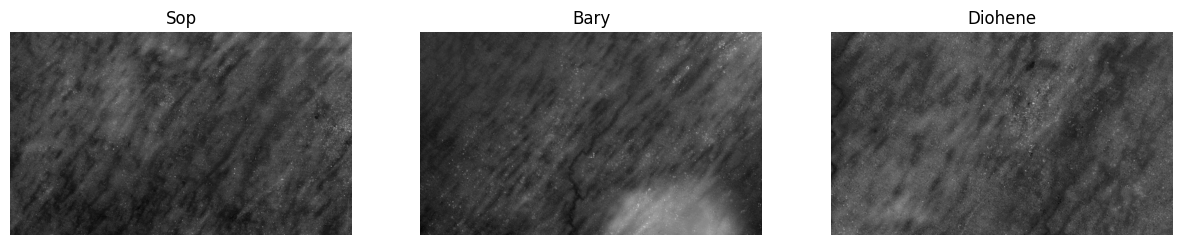

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_mnt_sop, cmap='gray')
axs[0].set_title('Sop')
axs[0].axis('off')

axs[1].imshow(img_mnt_bary, cmap='gray')
axs[1].set_title('Bary')
axs[1].axis('off')

axs[2].imshow(img_mnt_diohene, cmap='gray')
axs[2].set_title('Diohene')
axs[2].axis('off')

plt.show()


In [26]:
img_sop = img_sop.transpose([1,2,0])
img_bary = img_bary.transpose([1,2,0])
img_diohene = img_diohene.transpose([1,2,0])

mnt_sop = img_mnt_sop
mnt_bary = img_mnt_bary
mnt_diohene = img_mnt_diohene

In [27]:
img_sop.shape,img_bary.shape,img_diohene.shape,mnt_sop.shape

((489, 822, 13), (489, 822, 13), (489, 822, 13), (489, 822, 1))

In [28]:
red = img_diohene[:,:,3]
green = img_diohene[:,:,2]
blue = img_diohene[:,:,1]

rgb_sop = np.dstack((red,green,blue))

plt.figure(figsize=[20,20])
plt.imshow(rgb_sop*4)
plt.axis('off')

(-0.5, 821.5, 488.5, -0.5)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


In [29]:
sop_shapefile_path = '/content/MyDrive/MyDrive/GEE_SOP/SOP/SOP_DATA.shp'
bary_shapefile_path = '/content/MyDrive/MyDrive/GEE_SOP/BARY/BARY_DATA.shp'
diohene_shapefile_path = '/content/MyDrive/MyDrive/GEE_SOP/DIOHENE/DIOHENE_DATA.shp'

samples_sop = gpd.read_file(sop_shapefile_path)
samples_bary = gpd.read_file(bary_shapefile_path)
samples_diohene = gpd.read_file(diohene_shapefile_path)

In [67]:
# samples_sop = samples_sop.to_crs('EPSG:4326')
# samples_bary = samples_bary.to_crs('EPSG:4326')
# samples_diohene = samples_diohene.to_crs('EPSG:4326')

In [30]:
print(samples_sop.crs)
print(samples_bary.crs)
print(samples_diohene.crs)

EPSG:32628
EPSG:32628
EPSG:32628


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


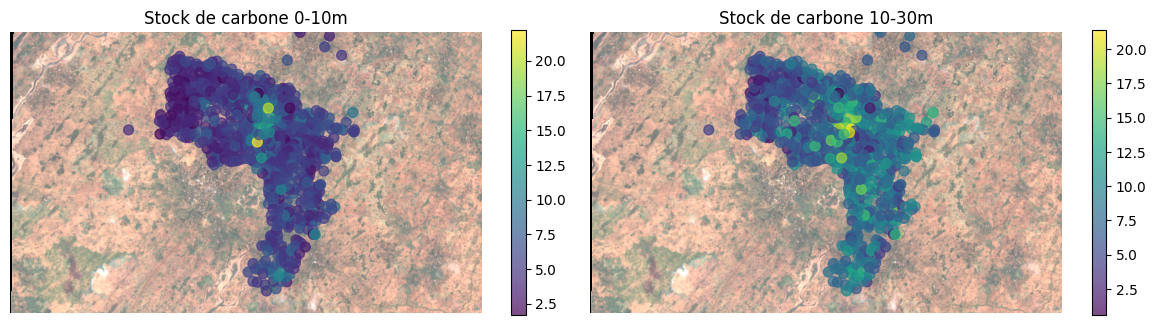

In [31]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from rasterio.plot import show

cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 0-'], cmap=cmap, s=50, alpha=0.7)
cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('Stock de carbone 0-10m')
show(rgb_sop.transpose([2, 0, 1]) * 4, transform=sop.transform, ax=axs[0])
axs[0].axis('off')

# Affichage du deuxième graphique
cax2 = axs[1].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 10'], cmap=cmap, s=50, alpha=0.7)
cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('Stock de carbone 10-30m')
show(rgb_sop.transpose([2, 0, 1]) * 4, transform=sop.transform, ax=axs[1])
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 0-'], cmap=cmap, s=50, alpha=0.7)
cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('Stock de carbone 0-10m')
show(mnt_sop, transform=sop.transform, ax=axs[0],cmap='gray')
axs[0].axis('off')

# Affichage du deuxième graphique
cax2 = axs[1].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 10'], cmap=cmap, s=50, alpha=0.7)
cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('Stock de carbone 10-30m')
show(mnt_sop, transform=sop.transform, ax=axs[1],cmap='gray')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [47]:
# Transformer l'image et le mnt pour la prédiction
predict_img_sop = np.nan_to_num(img_sop)
predict_img_sop = predict_img_sop.reshape(img_sop.shape[0]*img_sop.shape[1], img_sop.shape[2])

predict_mnt_sop = np.nan_to_num(mnt_sop)
predict_mnt_sop = predict_mnt_sop.reshape(mnt_sop.shape[0]*mnt_sop.shape[1], mnt_sop.shape[2])

predict_img_sop.shape,predict_mnt_sop.shape

((401958, 13), (401958, 1))

In [48]:
predict_img_bary = np.nan_to_num(img_bary)
predict_img_bary = predict_img_bary.reshape(img_bary.shape[0]*img_bary.shape[1], img_bary.shape[2])

predict_mnt_bary = np.nan_to_num(mnt_bary)
predict_mnt_bary = predict_mnt_bary.reshape(mnt_bary.shape[0]*mnt_bary.shape[1], mnt_bary.shape[2])

predict_img_bary.shape,predict_mnt_bary.shape

((401958, 13), (401958, 1))

In [49]:
predict_img_diohene = np.nan_to_num(img_diohene)
predict_img_diohene = predict_img_diohene.reshape(img_diohene.shape[0]*img_diohene.shape[1], img_diohene.shape[2])

predict_mnt_diohene = np.nan_to_num(mnt_diohene)
predict_mnt_diohene = predict_mnt_diohene.reshape(mnt_diohene.shape[0]*mnt_diohene.shape[1], mnt_diohene.shape[2])

predict_img_diohene.shape,predict_mnt_diohene.shape

((401958, 13), (401958, 1))

In [50]:
array_depth_0_10 = np.full((predict_img_sop.shape[0], 1), 10)
array_depth_10_30 = np.full((predict_img_sop.shape[0], 1), 30)

In [37]:
array_depth_0_10.shape,array_depth_10_30.shape

((401958, 1), (401958, 1))

In [51]:
def calculate_indices(bands):
    # Extraire les valeurs de pixel des bandes par indice
    B_1 = bands[:, 0]
    B_2 = bands[:, 1]
    B_3 = bands[:, 2]
    B_4 = bands[:, 3]
    B_5 = bands[:, 4]
    B_6 = bands[:, 5]
    B_7 = bands[:, 6]
    B_8 = bands[:, 7]
    B_8A = bands[:, 8]
    B_9 = bands[:, 9]
    B_10 = bands[:, 10]
    B_11 = bands[:, 11]
    B_12 = bands[:, 12]

    # Calcul du NDVI
    ndvi = (B_8 - B_4) / (B_8 + B_4)

    # Calcul du GDVI
    gdvi = (B_8 - B_3) / (B_8 + B_3)

    # Calcul du MSAVI2
    msavi2 = (2 * B_8 + 1 - np.sqrt((2 * B_8 + 1) ** 2 - 8 * (B_8 - B_4))) / 2

    # Calcul du PSRINIR
    psrinir = B_8 / B_5

    # Calcul du NDWI
    ndwi = (B_3 - B_8) / (B_3 + B_8)

    # Calcul du CIGreen
    cigreen = (B_4 - B_3) / (B_4 + B_3)

    return pd.DataFrame({
        'NDVI': ndvi,
        'GDVI': gdvi,
        'MSAVI2': msavi2,
        'PSRINIR': psrinir,
        'NDWI': ndwi,
        'CIGreen': cigreen
    })

In [52]:
indices_sop = calculate_indices(predict_img_sop)
predict_img_sop = pd.concat([pd.DataFrame(predict_img_sop), indices_sop], axis=1)

indices_bary = calculate_indices(predict_img_bary)
predict_img_bary = pd.concat([pd.DataFrame(predict_img_bary), indices_bary], axis=1)

indices_diohene = calculate_indices(predict_img_diohene)
predict_img_diohene = pd.concat([pd.DataFrame(predict_img_diohene), indices_diohene], axis=1)

<ipython-input-51-0b8ef7c19338>:18: RuntimeWarning: invalid value encountered in divide
  ndvi = (B_8 - B_4) / (B_8 + B_4)
<ipython-input-51-0b8ef7c19338>:21: RuntimeWarning: invalid value encountered in divide
  gdvi = (B_8 - B_3) / (B_8 + B_3)
<ipython-input-51-0b8ef7c19338>:27: RuntimeWarning: invalid value encountered in divide
  psrinir = B_8 / B_5
<ipython-input-51-0b8ef7c19338>:30: RuntimeWarning: invalid value encountered in divide
  ndwi = (B_3 - B_8) / (B_3 + B_8)
<ipython-input-51-0b8ef7c19338>:33: RuntimeWarning: invalid value encountered in divide
  cigreen = (B_4 - B_3) / (B_4 + B_3)
<ipython-input-51-0b8ef7c19338>:18: RuntimeWarning: invalid value encountered in divide
  ndvi = (B_8 - B_4) / (B_8 + B_4)
<ipython-input-51-0b8ef7c19338>:21: RuntimeWarning: invalid value encountered in divide
  gdvi = (B_8 - B_3) / (B_8 + B_3)
<ipython-input-51-0b8ef7c19338>:27: RuntimeWarning: invalid value encountered in divide
  psrinir = B_8 / B_5
<ipython-input-51-0b8ef7c19338>:30: Run

In [53]:
array_depth_0_10 = pd.DataFrame(array_depth_0_10)
array_depth_10_30 = pd.DataFrame(array_depth_10_30)

samples_sop_mnt = pd.concat((predict_img_sop, pd.DataFrame(predict_mnt_sop)), axis=1)
samples_sop_to_predict10 = pd.concat((samples_sop_mnt, array_depth_0_10), axis=1)
samples_sop_to_predict30 = pd.concat((samples_sop_mnt, array_depth_10_30), axis=1)

samples_bary_mnt = pd.concat((predict_img_bary, pd.DataFrame(predict_mnt_bary)), axis=1)
samples_bary_to_predict10 = pd.concat((samples_bary_mnt, array_depth_0_10), axis=1)
samples_bary_to_predict30 = pd.concat((samples_bary_mnt, array_depth_10_30), axis=1)

samples_diohene_mnt = pd.concat((predict_img_diohene, pd.DataFrame(predict_mnt_diohene)), axis=1)
samples_diohene_to_predict10 = pd.concat((samples_diohene_mnt, array_depth_0_10), axis=1)
samples_diohene_to_predict30 = pd.concat((samples_diohene_mnt, array_depth_10_30), axis=1)

In [54]:
samples_sop_to_predict10.shape,samples_sop_to_predict30.shape

((401958, 21), (401958, 21))

In [55]:
samples_sop_to_predict10 = np.array([samples_sop_to_predict10]).reshape(-1, samples_sop_to_predict10.shape[-1])
samples_sop_to_predict30 = np.array([samples_sop_to_predict30]).reshape(-1, samples_sop_to_predict30.shape[-1])

samples_bary_to_predict10 = np.array([samples_bary_to_predict10]).reshape(-1, samples_bary_to_predict10.shape[-1])
samples_bary_to_predict30 = np.array([samples_bary_to_predict30]).reshape(-1, samples_bary_to_predict30.shape[-1])

samples_diohene_to_predict10 = np.array([samples_diohene_to_predict10]).reshape(-1, samples_diohene_to_predict10.shape[-1])
samples_diohene_to_predict30 = np.array([samples_diohene_to_predict30]).reshape(-1, samples_diohene_to_predict30.shape[-1])

In [56]:
from sklearn.impute import SimpleImputer

#Imputer les valeurs manquantes
imputer = SimpleImputer(strategy='median')

samples_sop_to_predict10_imputed = imputer.fit_transform(samples_sop_to_predict10)
samples_sop_to_predict30_imputed = imputer.fit_transform(samples_sop_to_predict30)

samples_bary_to_predict10_imputed = imputer.fit_transform(samples_bary_to_predict10)
samples_bary_to_predict30_imputed = imputer.fit_transform(samples_bary_to_predict30)

samples_diohene_to_predict10_imputed = imputer.fit_transform(samples_diohene_to_predict10)
samples_diohene_to_predict30_imputed = imputer.fit_transform(samples_diohene_to_predict30)

In [57]:
# Faire des prédictions sur les données imputées
array_pred_sop10 = model.predict(samples_sop_to_predict10_imputed)
array_pred_sop10 = array_pred_sop10.reshape(img_sop.shape[0], img_sop.shape[1])

array_pred_sop30 = model.predict(samples_sop_to_predict30_imputed)
array_pred_sop30 = array_pred_sop30.reshape(img_sop.shape[0], img_sop.shape[1])

array_pred_bary10 = model.predict(samples_bary_to_predict10_imputed)
array_pred_bary10 = array_pred_bary10.reshape(img_bary.shape[0], img_bary.shape[1])

array_pred_bary30 = model.predict(samples_bary_to_predict30_imputed)
array_pred_bary30 = array_pred_bary30.reshape(img_bary.shape[0], img_bary.shape[1])

array_pred_diohene10 = model.predict(samples_diohene_to_predict10_imputed)
array_pred_diohene10 = array_pred_diohene10.reshape(img_diohene.shape[0], img_diohene.shape[1])

array_pred_diohene30 = model.predict(samples_diohene_to_predict30_imputed)
array_pred_diohene30 = array_pred_diohene30.reshape(img_diohene.shape[0], img_diohene.shape[1])

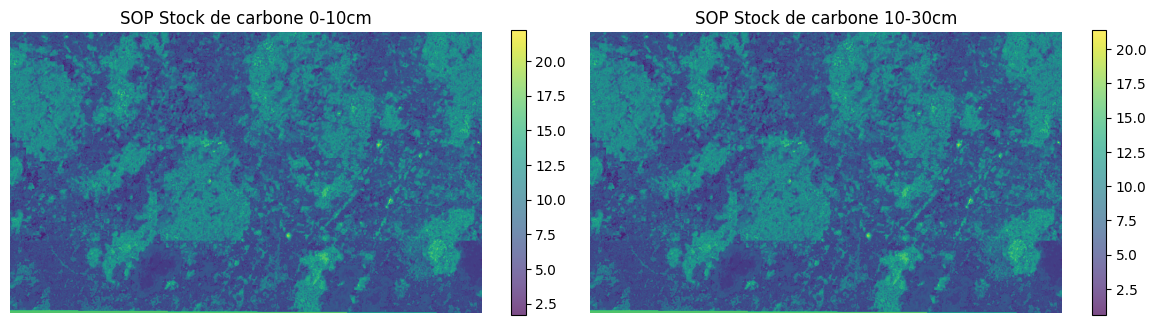

In [62]:
# Afficher les résultats
cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('SOP Stock de carbone 0-10cm')
axs[0].imshow(array_pred_sop10, cmap=cmap)
axs[0].axis('off')

cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('SOP Stock de carbone 10-30cm')
axs[1].imshow(array_pred_sop30, cmap=cmap)
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [63]:
# Afficher les résultats
cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('BARY Stock de carbone 0-10cm')
axs[0].imshow(array_pred_bary10, cmap=cmap)
axs[0].axis('off')

cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('BARY Stock de carbone 10-30cm')
axs[1].imshow(array_pred_bary30, cmap=cmap)
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [64]:
# Afficher les résultats
cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('DIOHENE Stock de carbone 0-10cm')
axs[0].imshow(array_pred_diohene10, cmap=cmap)
axs[0].axis('off')

cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('DIOHENE Stock de carbone 10-30cm')
axs[1].imshow(array_pred_diohene30, cmap=cmap)
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [70]:
samples_sop = samples_sop.to_crs('EPSG:4326')
samples_bary = samples_bary.to_crs('EPSG:4326')
samples_diohene = samples_diohene.to_crs('EPSG:4326')


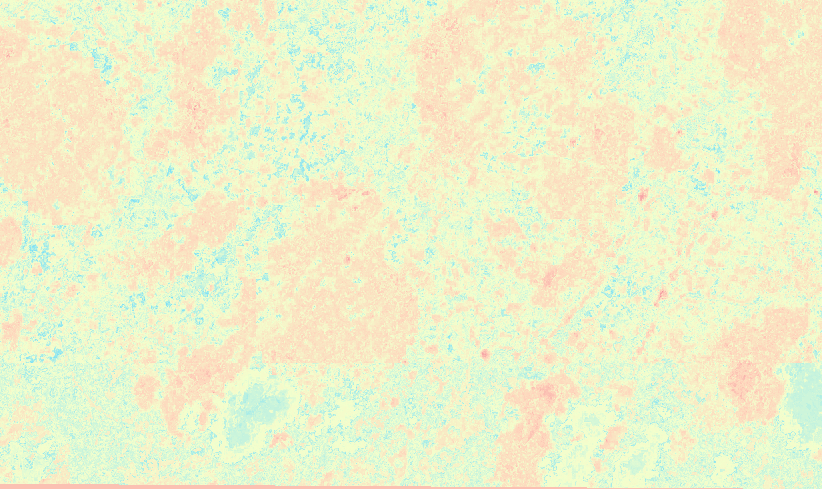

In [82]:
import folium
import pyproj
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import branca.colormap as cm

# Créer une carte OpenStreetMap centrée sur les coordonnées moyennes
center_lat = np.mean(samples_sop.geometry.y)
center_lon = np.mean(samples_sop.geometry.x)
map_osm = folium.Map(
                    location=[center_lat, center_lon],
                    zoom_start=10,
                    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                    attr = 'Esri',
                    name = 'Esri Satellite'
                    )

color_bar = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

cmap = LinearSegmentedColormap.from_list('custom', color_bar)
colors = cmap(array_pred_sop10 / np.max(array_pred_sop10))

img_array = np.zeros((len(array_pred_sop10), len(array_pred_sop10[0]), 4))
img_array[:, :, :] = colors

img_array[:, :, 3] = 0.6

# Ajouter l'image à la carte en tant que superposition
img_overlay = folium.raster_layers.ImageOverlay(
    image=img_array,
    bounds=[[min(samples_sop.geometry.y), min(samples_sop.geometry.x)], [max(samples_sop.geometry.y), max(samples_sop.geometry.x)]],
    origin='upper'
).add_to(map_osm)

# Créer une colormap dynamique en fonction des valeurs min et max de array_pred_sop10
dynamic_colormap = cm.StepColormap(colors=color_bar, vmin=array_pred_sop10.min(), vmax=array_pred_sop10.max())

# Ajouter la colormap à la carte
map_osm.add_child(dynamic_colormap)

# Ajouter une légende pour la colormap
dynamic_colormap.caption = 'Valeurs de carbone entre 0 et 10m'
map_osm.add_child(dynamic_colormap)

# Afficher la carte
map_osm



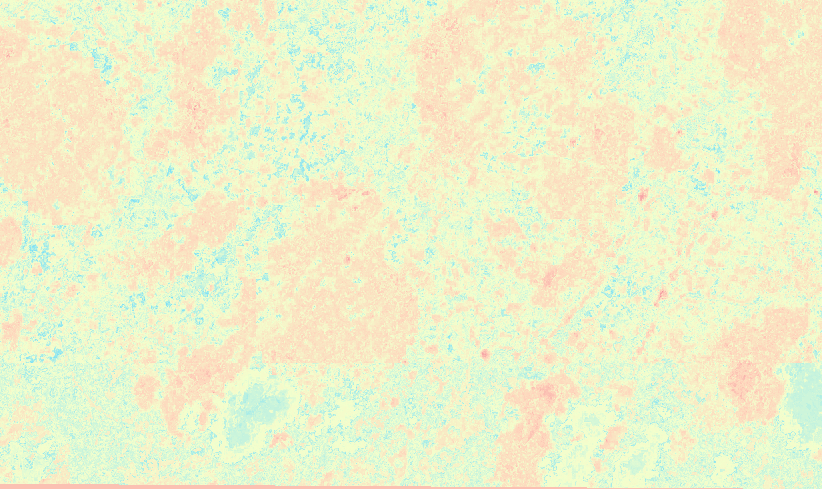

In [81]:
import folium
import pyproj
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import branca.colormap as cm

# Créer une carte OpenStreetMap centrée sur les coordonnées moyennes
center_lat = np.mean(samples_sop.geometry.y)
center_lon = np.mean(samples_sop.geometry.x)
map_osm = folium.Map(
                    location=[center_lat, center_lon],
                    zoom_start=10,
                    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                    attr = 'Esri',
                    name = 'Esri Satellite'
                    )

color_bar = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

# Convertir les valeurs prédites en couleurs RVBA
cmap = LinearSegmentedColormap.from_list('custom', color_bar)
colors = cmap(array_pred_sop30 / np.max(array_pred_sop30))

# Créer une matrice d'images pour la superposition
img_array = np.zeros((len(array_pred_sop30), len(array_pred_sop30[0]), 4))  # Ajouter une dimension pour l'opacité
img_array[:, :, :] = colors  # Copier les valeurs de couleur directement

# Définir l'opacité à 0.6 pour toutes les valeurs
img_array[:, :, 3] = 0.6

# Ajouter l'image à la carte en tant que superposition
img_overlay = folium.raster_layers.ImageOverlay(
    image=img_array,
    bounds=[[min(samples_sop.geometry.y), min(samples_sop.geometry.x)], [max(samples_sop.geometry.y), max(samples_sop.geometry.x)]],
    origin='upper'
).add_to(map_osm)

# Créer une colormap dynamique en fonction des valeurs min et max de array_pred_sop30
dynamic_colormap = cm.StepColormap(colors=color_bar, vmin=array_pred_sop30.min(), vmax=array_pred_sop30.max())

# Ajouter la colormap à la carte
map_osm.add_child(dynamic_colormap)

# Ajouter une légende pour la colormap
dynamic_colormap.caption = 'Valeurs de carbone entre 10 et 30m'
map_osm.add_child(dynamic_colormap)

# Afficher la carte
map_osm
